## Table of Contents

- [1 - Packages](#1)
- [2 - Load MetaData csv file](#2)
- [3 - Perform Explarotary data analysis](#3)
    - [3.1 - Checking the duplicate elements in the dataset](#3-1)
    - [3.2 - Create dataframes for training and test data](#3-2)
- [4 - Create directories and place data into the directories](#4)
- [5 - Load data to visualize training and test set's skewness](#5)
    - [5.1 - Visualize training and test set](#5-1)
    
- [6 - Perform Data Augmentation on training set](#6)
    - [6.1 - Visualize Augmented Training Set](#6-1)
- [7 - Load and Pre-Process the data](#7)
- [8 - Model Specification](#8)
- [9 - Model training (CheckPoint and Early Stopping)](#9)
- [10 - Model Evaluation](#10)
    - [6.1 - Accuracy on test set](#10-1)
    - [6.1 - Classificaton report](#10-2)
    - [6.1 - Confusion matrix](#10-3)
    - [6.1 - ROC](#10-4)
- [11 - Save Model for later use](#11)

<a name='1'></a>
# 1 - Packages
As usual, begin by loading in the packages.

In [50]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,GlobalAveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import pathlib
import seaborn as sns
from tensorflow.keras import layers

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [51]:
import os
print(os.getcwd())

/Users/eaqibhadi/Desktop/final project


In [52]:
os.chdir('/Users/eaqibhadi/Desktop/final project')
print(os.getcwd())

/Users/eaqibhadi/Desktop/final project


<a name='2'></a>
# 2 - Load Metadata csv file

In [53]:
data_pd = pd.read_csv('HAM10000_metadata.csv')
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


<a name='3'></a>
# 3 - Perform Explarotary data analysis

<a name='3-1'></a>
## 3.1 - Checking the duplicate elements in the dataset

In [54]:
df_count = data_pd.groupby('lesion_id').count()
df_count

,image_id,dx,dx_type,age,sex,localization
lesion_id,,,,,,
HAM_0000000,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1
...,...,...,...,...,...,...
HAM_0007624,1,1,1,1,1,1
HAM_0007625,2,2,2,2,2,2
HAM_0007626,1,1,1,1,1,1


In [55]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)

In [56]:
df_count

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1
...,...,...,...,...,...,...,...
5509,HAM_0007622,1,1,1,1,1,1
5510,HAM_0007623,1,1,1,1,1,1
5511,HAM_0007624,1,1,1,1,1,1
5512,HAM_0007626,1,1,1,1,1,1


In [57]:
def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no' 
    else:
        return 'duplicates'

In [58]:
data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,duplicates
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,duplicates
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,duplicates
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,duplicates


In [59]:
df_count = data_pd[data_pd['is_duplicate'] == 'no']

In [60]:
df_count

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
10,HAM_0001396,ISIC_0025276,bkl,histo,55.0,female,trunk,no
15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,no
20,HAM_0006071,ISIC_0032343,bkl,histo,70.0,female,face,no
33,HAM_0005612,ISIC_0024981,bkl,histo,80.0,male,scalp,no
34,HAM_0005388,ISIC_0027815,bkl,histo,80.0,male,chest,no
...,...,...,...,...,...,...,...,...
9988,HAM_0001036,ISIC_0027588,akiec,histo,50.0,female,face,no
9990,HAM_0004462,ISIC_0027334,akiec,histo,45.0,male,trunk,no
9991,HAM_0001152,ISIC_0030133,akiec,histo,65.0,male,face,no
10001,HAM_0000020,ISIC_0031922,akiec,histo,60.0,female,face,no


<a name='3-2'></a>
## 3.2 - Create dataframes for training and test data 
#### test dataframe is created on unique data using 15 percent split size and remaing data is put into training dataframe

In [61]:
train, test_df = train_test_split(df_count, test_size=0.15, stratify=df_count['dx'])

In [62]:
def identify_trainOrtest(x):
    test_data = set(test_df['image_id'])
    if str(x) in test_data:
        return 'test'
    else:
        return 'train'

#creating train_df
data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']
train_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate,train_test_split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates,train
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,duplicates,train
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,duplicates,train
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,duplicates,train
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,duplicates,train


In [63]:
test_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
9488,HAM_0004572,ISIC_0032868,nv,consensus,30.0,male,back,no
4814,HAM_0004797,ISIC_0024895,nv,follow_up,50.0,female,back,no
2460,HAM_0003829,ISIC_0026349,vasc,consensus,60.0,female,trunk,no
5364,HAM_0001951,ISIC_0030216,nv,follow_up,80.0,male,abdomen,no
2199,HAM_0006061,ISIC_0027179,mel,histo,85.0,male,lower extremity,no
...,...,...,...,...,...,...,...,...
4474,HAM_0004468,ISIC_0030480,nv,follow_up,45.0,female,lower extremity,no
664,HAM_0006732,ISIC_0024336,bkl,histo,50.0,female,lower extremity,no
1053,HAM_0003982,ISIC_0030056,bkl,consensus,50.0,male,trunk,no
2978,HAM_0006510,ISIC_0029828,nv,follow_up,55.0,female,lower extremity,no


In [64]:
# Image id of train and test images
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

In [65]:
len(train_list)

9187

In [66]:
len(test_list)

828

In [67]:
# Set the image_id as the index in data_pd
data_pd.set_index('image_id', inplace=True)

In [68]:
train_dir = os.path.join('HAM10000', 'train_dir')
test_dir = os.path.join('HAM10000', 'test_dir')

<a name='4'></a>
# 4 - Create directories and place data into the directories

In [30]:
os.mkdir(train_dir)
os.mkdir(test_dir)

In [25]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [32]:
for i in targetnames:
    directory1=train_dir+'/'+i
    directory2=test_dir+'/'+i
    os.mkdir(directory1)
    os.mkdir(directory2)

In [33]:
for image in train_list:
    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image 
    source = os.path.join('images', file_name)

    # copying the image from the source to target file
    target = os.path.join(train_dir, label, file_name)

    shutil.copyfile(source, target)

In [37]:
for image in test_list:

    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image 
    source = os.path.join('images', file_name)

    # copying the image from the source to target file
    target = os.path.join(test_dir, label, file_name)

    shutil.copyfile(source, target)

<a name='5'></a>
# 5 - Load data to visualize training and test set's skewness

In [20]:
train_path = 'HAM10000/train_dir'
test_path = 'HAM10000/test_dir'
batch_size=16

In [21]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input)

In [22]:
image_size = 224
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 9187 images belonging to 7 classes.

Test Batches: 
Found 828 images belonging to 7 classes.


<a name='5-1'></a>
## 5.1 - Visualize training and test set

In [23]:
output_dir_train = pathlib.Path('HAM10000/train_dir/')
image_count_train = len(list(output_dir_train.glob('*/*.jpg')))
print(f'Training images are: {image_count_train}')

output_dir_test = pathlib.Path('HAM10000/test_dir/')
image_count_train = len(list(output_dir_test.glob('*/*.jpg')))
print(f'Testing images are: {image_count_train}')

Training images are: 9187
Testing images are: 828


total training image count = 9187 

-------------------------------------
Class name =  akiec
count      =  304
proportion =  0.03309023620333079
-------------------------------------
Class name =  bcc
count      =  488
proportion =  0.05311853706324154
-------------------------------------
Class name =  bkl
count      =  1033
proportion =  0.1124414934146076
-------------------------------------
Class name =  df
count      =  109
proportion =  0.011864591270273213
-------------------------------------
Class name =  mel
count      =  1079
proportion =  0.11744856862958529
-------------------------------------
Class name =  nv
count      =  6042
proportion =  0.6576684445411995
-------------------------------------
Class name =  vasc
count      =  132
proportion =  0.014368128877762055
-------------------------------------


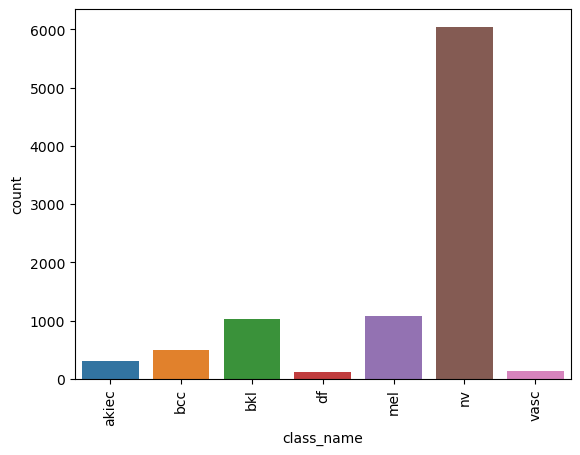

total training image count = 828 

-------------------------------------
Class name =  akiec
count      =  23
proportion =  0.027777777777777776
-------------------------------------
Class name =  bcc
count      =  26
proportion =  0.03140096618357488
-------------------------------------
Class name =  bkl
count      =  66
proportion =  0.07971014492753623
-------------------------------------
Class name =  df
count      =  6
proportion =  0.007246376811594203
-------------------------------------
Class name =  mel
count      =  34
proportion =  0.04106280193236715
-------------------------------------
Class name =  nv
count      =  663
proportion =  0.8007246376811594
-------------------------------------
Class name =  vasc
count      =  10
proportion =  0.012077294685990338
-------------------------------------


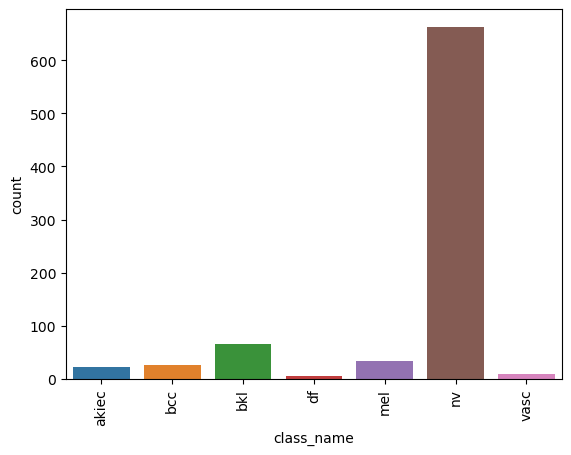

In [26]:
# Visualize Training Set

num_classes = len(targetnames)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
    count = len(list(output_dir_train.glob(targetnames[i]+'/*.jpg')))
    total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
    count = len(list(output_dir_train.glob(targetnames[i]+'/*.jpg')))
    print("Class name = ",targetnames[i])
    print("count      = ",count)
    print("proportion = ",count/total)
    print("-------------------------------------")
    all_count.append(count)
    class_name.append(targetnames[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()



# Visualize Validation Set
num_classes = len(targetnames)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
    count = len(list(output_dir_test.glob(targetnames[i]+'/*.jpg')))
    total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
    count = len(list(output_dir_test.glob(targetnames[i]+'/*.jpg')))
    print("Class name = ",targetnames[i])
    print("count      = ",count)
    print("proportion = ",count/total)
    print("-------------------------------------")
    all_count.append(count)
    class_name.append(targetnames[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

### Dataset Looks Highly skewed, still we perform data augmentation on training set


<a name='6'></a>
# 6 - Perform Data Augmentation on training set

In [43]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [44]:


# Augmenting images and storing them in temporary directories 
for img_class in targetnames:

    #creating temporary directories
    # creating a base directory
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # creating a subdirectory inside the base directory for images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_list = os.listdir('HAM10000/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir 
    for file_name in img_list:

        # path of source image in training directory
        source = os.path.join('HAM10000/train_dir/' + img_class, file_name)

        # creating a target directory to send images 
        target = os.path.join(img_dir, file_name)

        # copying the image from the source to target file
        shutil.copyfile(source, target)

    # Temporary augumented dataset directory.
    source_path = aug_dir

    # Augmented images will be saved to training directory
    save_path = 'HAM10000/train_dir/' + img_class

    # Creating Image Data Generator to augment images
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(

        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'

    )

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(source_path,save_to_dir=save_path,save_format='jpg',target_size=(224, 224),batch_size=batch_size)

    # Generate the augmented images
    aug_images = 8000 

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    # creating 8000 augmented images per class
    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # delete temporary directory 
    shutil.rmtree('aug_dir')


Found 304 images belonging to 1 classes.
Found 488 images belonging to 1 classes.
Found 1033 images belonging to 1 classes.
Found 109 images belonging to 1 classes.
Found 1079 images belonging to 1 classes.
Found 6042 images belonging to 1 classes.
Found 132 images belonging to 1 classes.


<a name='6-1'></a>
### 6.1 - Visualize Augmented Training and test Set

In [69]:
output_dir_train = pathlib.Path('HAM10000/train_dir/')
image_count_train = len(list(output_dir_train.glob('*/*.jpg')))
print(f'Training images are: {image_count_train}')

output_dir_test = pathlib.Path('HAM10000/test_dir/')
image_count_train = len(list(output_dir_test.glob('*/*.jpg')))
print(f'Testing images are: {image_count_train}')

Training images are: 51698
Testing images are: 828


total training image count = 51698 

-------------------------------------
Class name =  akiec
count      =  6991
proportion =  0.13522766838175557
-------------------------------------
Class name =  bcc
count      =  7858
proportion =  0.15199814306162715
-------------------------------------
Class name =  bkl
count      =  7931
proportion =  0.15341018994932107
-------------------------------------
Class name =  df
count      =  5877
proportion =  0.11367944601338544
-------------------------------------
Class name =  mel
count      =  7903
proportion =  0.1528685829239042
-------------------------------------
Class name =  nv
count      =  8042
proportion =  0.15555727494293783
-------------------------------------
Class name =  vasc
count      =  7096
proportion =  0.13725869472706875
-------------------------------------


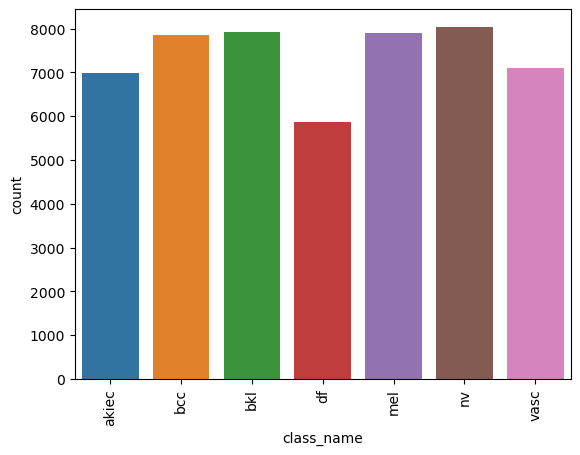

total training image count = 828 

-------------------------------------
Class name =  akiec
count      =  23
proportion =  0.027777777777777776
-------------------------------------
Class name =  bcc
count      =  26
proportion =  0.03140096618357488
-------------------------------------
Class name =  bkl
count      =  66
proportion =  0.07971014492753623
-------------------------------------
Class name =  df
count      =  6
proportion =  0.007246376811594203
-------------------------------------
Class name =  mel
count      =  34
proportion =  0.04106280193236715
-------------------------------------
Class name =  nv
count      =  663
proportion =  0.8007246376811594
-------------------------------------
Class name =  vasc
count      =  10
proportion =  0.012077294685990338
-------------------------------------


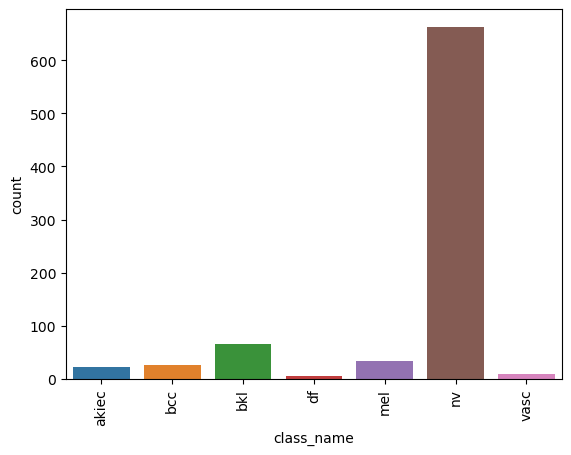

In [70]:
# Visualize Training Set

num_classes = len(targetnames)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
    count = len(list(output_dir_train.glob(targetnames[i]+'/*.jpg')))
    total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
    count = len(list(output_dir_train.glob(targetnames[i]+'/*.jpg')))
    print("Class name = ",targetnames[i])
    print("count      = ",count)
    print("proportion = ",count/total)
    print("-------------------------------------")
    all_count.append(count)
    class_name.append(targetnames[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()



# Visualize Validation Set
num_classes = len(targetnames)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
    count = len(list(output_dir_test.glob(targetnames[i]+'/*.jpg')))
    total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
    count = len(list(output_dir_test.glob(targetnames[i]+'/*.jpg')))
    print("Class name = ",targetnames[i])
    print("count      = ",count)
    print("proportion = ",count/total)
    print("-------------------------------------")
    all_count.append(count)
    class_name.append(targetnames[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

<a name='7'></a>
# 7 - Load and Pre-Process the data

In [71]:
train_path = 'HAM10000/train_dir'
test_path = 'HAM10000/test_dir'
batch_size=16

In [72]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input)

In [73]:
image_size = 224
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 51698 images belonging to 7 classes.

Test Batches: 
Found 828 images belonging to 7 classes.


<a name='8'></a>
# 8 - Model specfication

In [74]:
resnet = tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
)

# Exclude the last 3 layers of the model.
conv = resnet.layers[-3].output

In [75]:
output = GlobalAveragePooling2D()(conv)
output = Dense(7, activation='softmax')(output)
model = Model(inputs=resnet.input, outputs=output)

In [76]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

<a name='9'></a>
# 9 - Model training (CheckPoint and Early Stopping)

In [77]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [78]:
checkpoint=  ModelCheckpoint(filepath = 'ResNet50augmented.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)

In [79]:
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=20, min_delta=0.001)

In [69]:
history = model.fit(train_batches,
                    steps_per_epoch=(len(train_df)/10),
                    epochs=300,
                    verbose=1,
                    validation_data=test_batches,
                    validation_steps=len(test_df)/batch_size,
                    callbacks=[checkpoint,Earlystop]
                   )

Epoch 1/300


2023-04-05 17:29:01.243778: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-05 17:29:03.115948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


919/918 [==============================] - ETA: 0s - loss: 0.9612 - accuracy: 0.6525

2023-04-05 17:35:17.948402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


918/918 [==============================] - 384s 414ms/step - loss: 0.9612 - accuracy: 0.6525 - val_loss: 0.6808 - val_accuracy: 0.7923
Epoch 2/300
918/918 [==============================] - 429s 467ms/step - loss: 0.6575 - accuracy: 0.7547 - val_loss: 1.4644 - val_accuracy: 0.4553
Epoch 3/300
918/918 [==============================] - 455s 495ms/step - loss: 0.5451 - accuracy: 0.7982 - val_loss: 0.7969 - val_accuracy: 0.7585
Epoch 4/300
918/918 [==============================] - 439s 477ms/step - loss: 0.4642 - accuracy: 0.8260 - val_loss: 0.4049 - val_accuracy: 0.8720
Epoch 5/300
918/918 [==============================] - 450s 490ms/step - loss: 0.3915 - accuracy: 0.8538 - val_loss: 0.5102 - val_accuracy: 0.8599
Epoch 6/300
918/918 [==============================] - 426s 464ms/step - loss: 0.3401 - accuracy: 0.8726 - val_loss: 0.5001 - val_accuracy: 0.8430
Epoch 7/300
918/918 [==============================] - 433s 472ms/step - loss: 0.3077 - accuracy: 0.8872 - val_loss: 0.3025 - val_

<a name='10'></a>
# 10 - Model Evaluation

In [80]:
from tensorflow.keras import models
model.load_weights("ResNet50augmented.hdf5")

In [81]:
predictions = model.predict(test_batches,
                            #steps=len(test_df)/batch_size,
                            verbose=1).round(2)

2023-05-16 21:01:49.337931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


52/52 [==============================] - 7s 122ms/step


<a name='10-1'></a>
## 10.1 - Accuracy on test set

In [82]:
(eval_loss, eval_accuracy) = model.evaluate(test_batches, batch_size=batch_size,verbose=1)

2023-05-16 21:01:56.503682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


52/52 [==============================] - 7s 126ms/step - loss: 0.2580 - accuracy: 0.9251


<a name='10-2'></a>
## 10.2 - Classification report

In [83]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.79      0.83      0.81        23
         bcc       0.73      0.92      0.81        26
         bkl       0.82      0.80      0.81        66
          df       1.00      0.50      0.67         6
         mel       0.54      0.41      0.47        34
          nv       0.96      0.97      0.97       663
        vasc       1.00      0.90      0.95        10

    accuracy                           0.92       828
   macro avg       0.83      0.76      0.78       828
weighted avg       0.92      0.92      0.92       828



<a name='10-3'></a>
## 10.3 - Confusion matrix

<Axes: >

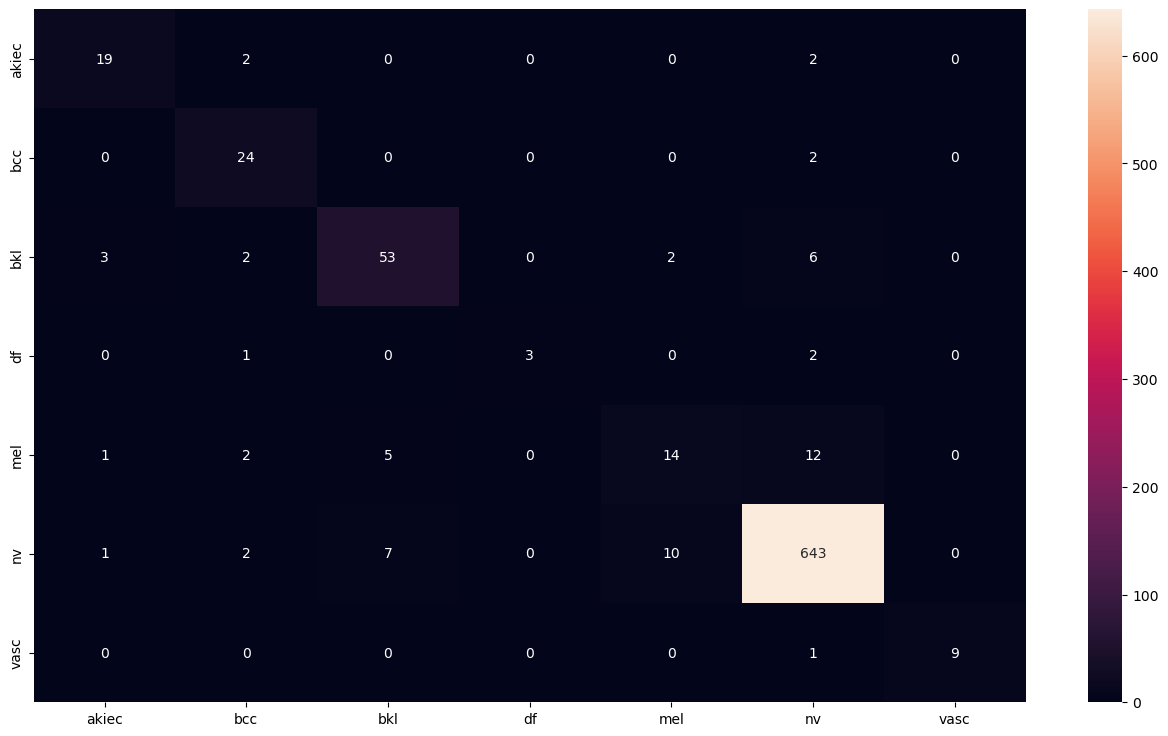

In [84]:
plt.figure(figsize=(16,9))
y_pred_labels = [ np.argmax(label) for label in predictions]
cm = confusion_matrix(y_true, y_pred_labels )
sns.heatmap(cm, annot = True, fmt='d', xticklabels=targetnames, yticklabels=targetnames)

<a name='10-4'></a>
## 10.4 - ROC

In [85]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9728328382392655
The ROC AUC score of bcc is: 0.9940053711874162
The ROC AUC score of bkl is: 0.9561063389803548
The ROC AUC score of df is: 0.9133211678832117
The ROC AUC score of mel is: 0.9292672988590902
The ROC AUC score of nv is: 0.9821883998354587
The ROC AUC score of vasc is: 0.9993276283618582


In [86]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])
    

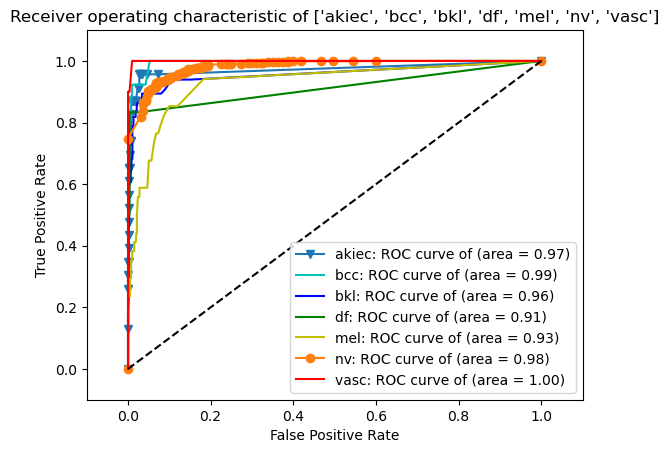

In [87]:

plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames)
plt.legend(loc="lower right")
plt.show()

<a name='11'></a>
# 11 - Save Model for later use

In [90]:
model.save('augmented_model.h5')